In [1]:
!git clone https://github.com/giovaniceotto/RocketPy.git
import os

fatal: destination path 'RocketPy' already exists and is not an empty directory.


In [2]:
import sys; 
print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:45:29) 
[GCC 10.4.0]


In [3]:
!pip install --upgrade cffi
!pip install rocketpy --pre netCDF4

import sys

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
#get_ipython().run_line_magic('matplotlib', 'widget')

In [6]:
pip install rocketcea

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [9]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install jsonpickle

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install windrose

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install simplekml

Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install --upgrade cffi

In [14]:
pip install --upgrade rocketpy

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install timezonefinder

Note: you may need to restart the kernel to use updated packages.


In [16]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

from rocketpy import Rocket, motors, simulation, environment, mathutils
from rocketpy.rocket import rocket
from rocketpy.motors import liquid_motor, tank, tank_geometry, fluid
from rocketpy.simulation import flight
from rocketpy.environment import environment
from rocketpy.mathutils import function


If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [17]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

## Setting Up Thrust Curve


In [18]:
import rocketcea
import os
import numpy as np
import scipy
from scipy.optimize import minimize
import tkinter as tk
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.matplotlib_fname())
from rocketcea.cea_obj import CEA_Obj
import pandas as pd
import math
import datetime

class propellant:
    def __init__(self,name, density, viscosity,tank_length, tank_radius, temperature):
        self.density = density
        self.viscosity = viscosity
        self.temp = temperature
        self.rad = tank_radius
        self.length = tank_length
        self.name = name
        return None
    def __str__(self) -> str:
        return self.name

/srv/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


In [19]:
#matplotlib widget

/tmp/ipykernel_443/2598743741.py:61: RuntimeWarning: invalid value encountered in scalar power
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)


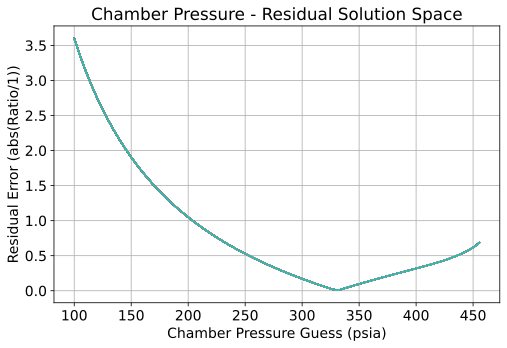

In [309]:
#Fluid Properties (SI units)
rho_LOX = 1140.0
rho_ETH = 798.0

#System Test Data Results
CdA_inj_feed_LOX = 7.5376*10**(-6) #Test For Cd
CdA_inj_ETH = 0.000013588 #Test For Cd

CdA_feed_LOX = 38.503*10**(-6) #Test For Cd NEEDS DATA
CdA_feed_ETH = 0.000022120 #Test For Cd


#Hydraulic Resistance Terms
R_ox_inj = 1/(2*(CdA_inj_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_inj = 1/(2*(CdA_inj_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox_feed = 1/(2*(CdA_feed_LOX**2)) #dP=Rhyd*mdot^2/rho
R_eth_feed = 1/(2*(CdA_feed_ETH**2)) #dP=Rhyd*mdot^2/rho

R_ox = R_ox_inj + R_ox_feed #Equivalent Hydraulic System Resistance
R_eth = R_eth_inj + R_ox_feed #Equivalent Hydraulic System Resistance

#Tank Properties
gamma_tanks = 1.41 #1.41=GN2, 1.67=GHe
V_oxtank = 6.926 #L
V_ethtank = 7.57 #L

V_oxinit = 3.8  #L OPTMIMIZE THIS
V_ethinit = 4.2 #L OPTIMIZE THIS

V_oxgas = V_oxtank-V_oxinit
V_ethgas = V_ethtank - V_ethinit

#Initial Tank Pressures
P_tank_ox_psi = 590 #psia
P_oxtank = P_tank_ox_psi*6895 #Pa

P_tank_eth_psi = 460 #psia
P_ethtank = P_tank_eth_psi*6895 #Pa

#define cstar efficiency: completeion of energy release. See RPE Pg64
Efficiency = 0.91
chamber = CEA_Obj(propName="", oxName="LOX", fuelName="C2H5OH") #initializs CEA object

#define Throat Diameter, Area
Dt = 27.54/1000 #m
At = (Dt**2)/4*math.pi

# Initialize Array
Residual = []

#create Chamber Pressure Guess Array
Pc_test_psi = np.linspace(100.0, (max(P_tank_ox_psi, P_tank_eth_psi)-1), 100) #psia
Pc_test = Pc_test_psi*6895 #Pa

#solve residual for each pressure guess
for i in range(len(Pc_test)):

    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - Pc_test[i]))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - Pc_test[i]))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio_test = mdot_ox/mdot_eth

    #solve mass flow from CEA
    Cstar_fps = chamber.get_Cstar(Pc=Pc_test_psi[i], MR=OF_ratio_test) #see RPE pg64
    Cstar = Cstar_fps*0.3048 #m
    mdot_CEA = Pc_test[i]*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = (mdot_CEA-mdot_fluid)/mdot_CEA
    Residual.append(abs(error))

    plt.plot(Pc_test_psi[:i+1], Residual[:i+1])
    plt.xlabel('Chamber Pressure Guess (psia)')
    plt.ylabel('Residual Error (abs(Ratio/1))')
    plt.title('Chamber Pressure - Residual Solution Space')
    plt.grid(True)


# Display the final plot after the loop
plt.show()

def Calculate_Residual(Pc, P_oxtank, P_ethtank):
    #solve mass flow from fluid resistances
    mdot_ox = ((1/R_ox)*rho_LOX*(P_oxtank - (Pc*6895)))**(1/2)
    mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)
    mdot_fluid = mdot_ox + mdot_eth
    #get OF ratio
    OF_ratio = mdot_ox/mdot_eth
    #solve mass flow from CEA
    Cstar_fps = chamber.get_Cstar(Pc = Pc[0], MR = OF_ratio[0]) #see RPE pg64
    Cstar = float(Cstar_fps*0.3048) #m/s
    if Cstar == 0:
        print("CSTAR ZERO")
        print(f"PC = {Pc[0]}")
        mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
    else:
        mdot_CEA_res = (Pc*6895)*At/(Cstar*Efficiency) #kg/s

    #compare residual, append to array
    error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res

    global OF_ratio_glob
    OF_ratio_glob = float(OF_ratio[0])

    global mdot_total_glob
    mdot_total_glob = float(mdot_fluid[0])

    if OF_ratio > 2.5: #tank pressure drop eqs breaking
        error = 5000
        print("OF RATIO ERROR")

    return abs(error)

def GradientDescent(guess, P_oxtank, P_ethtank):
    # Use scipy optimize minimize with residual function to find Chamber Pressure
    result = minimize(
        Calculate_Residual,
        guess,
        args = (P_oxtank, P_ethtank),
        bounds = [(85, min([P_oxtank/6895, P_ethtank/6895]))],
    )
    P_chamber = result.x[0]
    # t = type(P_chamber)
    #print(f"Pchamb TYPE {t}")
    OF = OF_ratio_glob
    isp = chamber.estimate_Ambient_Isp(Pc=P_chamber,MR=OF,eps=4.35)[0]
    thrust = 9.8*isp*(mdot_total_glob)/1000 #kN
    print(f"Thrust {thrust}")
    massflow_total = mdot_total_glob
    print(f"massflow {massflow_total}")
    #print(f"PC {P_chamber/6895} and MR {OF_ratio} at {i*dt}")

    return P_chamber, thrust, OF, massflow_total

TIMESTEP 0.08032128514056225
Thrust 2.1083532090489503
massflow 0.95591418189958
OF RATIO ERROR
CSTAR ZERO
PC = 450.79330382692706
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 450.79330382692706
OF RATIO ERROR
Thrust 2.082138649702463
massflow 0.9408356425349329


/tmp/ipykernel_443/2598743741.py:91: RuntimeWarning: divide by zero encountered in divide
  OF_ratio = mdot_ox/mdot_eth
/tmp/ipykernel_443/2598743741.py:98: RuntimeWarning: divide by zero encountered in divide
  mdot_CEA_res = Pc*6895*At/(abs(Cstar)*Efficiency)
/tmp/ipykernel_443/2598743741.py:103: RuntimeWarning: invalid value encountered in divide
  error = (mdot_CEA_res-mdot_fluid)/mdot_CEA_res


OF RATIO ERROR
CSTAR ZERO
PC = 442.08609142395574
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 442.08609142395574
OF RATIO ERROR
Thrust 2.0566637103392345
massflow 0.9264326293588527
Thrust 2.031897870542372
massflow 0.9126569024099058
OF RATIO ERROR
CSTAR ZERO
PC = 426.00539649903527
OF RATIO ERROR
Thrust 2.0078120544739506
massflow 0.8994649812134132
Thrust 1.9843789262077742
massflow 0.8868173997989661
Thrust 1.961571952921374
massflow 0.8746785641615971
Thrust 1.9393665046312685
massflow 0.8630158169149393
OF RATIO ERROR
CSTAR ZERO
PC = 398.25852672589315
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 398.25852672589315
OF RATIO ERROR
Thrust 1.9177386246278028
massflow 0.8517995896916635
Thrust 1.8966656894460958
massflow 0.8410027438080225
OF RATIO ERROR
CSTAR ZERO
PC = 386.1797415398087
OF RATIO ERROR
Thrust 1.8761263424388992
massflow 0.8306003315125273
Thrust 1.8560997162559594
massflow 0.8205696313808756
OF RATIO ERROR
CSTAR ZERO
PC = 375.0849729510191
OF RATIO ERROR
OF RATIO 

/tmp/ipykernel_443/2598743741.py:88: RuntimeWarning: invalid value encountered in sqrt
  mdot_eth = ((1/R_eth)*rho_ETH*(P_ethtank - (Pc*6895)))**(1/2)


CSTAR ZERO
PC = 293.0710356282592
OF RATIO ERROR
Thrust 1.5018127203642622
massflow 0.658418328455782
OF RATIO ERROR
CSTAR ZERO
PC = 290.46034416276564
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 290.46034416276564
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 290.46034416276564
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 290.46034416276564
OF RATIO ERROR
Thrust 1.4898835068878118
massflow 0.6533807806503547
OF RATIO ERROR
CSTAR ZERO
PC = 287.91424207051324
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 287.91424207051324
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 287.91424207051324
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 287.91424207051324
OF RATIO ERROR
Thrust 1.478172378699769
massflow 0.6484575275870366
OF RATIO ERROR
CSTAR ZERO
PC = 285.43010638646155
OF RATIO ERROR
Thrust 1.4666730642811698
massflow 0.6436442369820561
OF RATIO ERROR
CSTAR ZERO
PC = 283.00546052878474
OF RATIO ERROR
OF RATIO ERROR
CSTAR ZERO
PC = 283.00546052878474
OF RATIO ERROR
OF RATIO ERROR
CSTAR Z

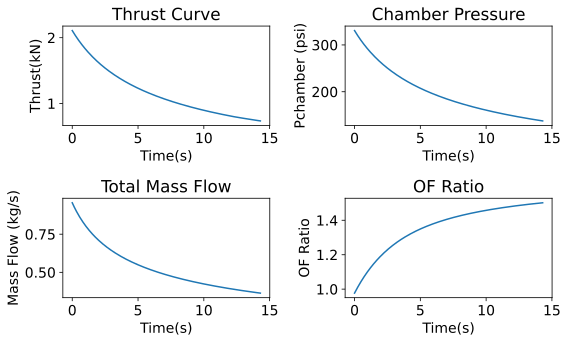

In [310]:
import csv

#reference thrust curve
iterations = 250
time = np.linspace(0, 20, iterations) #200 pts from 0 to 15 seconds
dt = float(time[1]-time[0])
print(f"TIMESTEP {dt}")
OF_array = []
Thrust_array = []
P_chamber_array = []
md_ox_array = []
md_fuel_array = []
mdtot_array = []
fin = 0
for i in range(len(time)): #perform this for every timestep in the profile

    if i == 0:
        Pc_guess = 350
    else:
        Pc_guess = P_chamber_last-2.5

    P_chamber, Thrust, OF, md_tot = GradientDescent(Pc_guess, P_oxtank, P_ethtank)
    md_ox = md_tot/(1+1/OF)
    md_eth = md_tot-md_ox
    Ox_inj_dp = (R_ox_inj)*(md_ox**2)/rho_LOX / 6894
    #print(f"OX_INJ: {Ox_inj_dp}")
    OX_FEED_dP = (R_ox_feed)*(md_ox**2)/rho_LOX / 6894
    #print(f"OX_FEED_dP: {OX_FEED_dP}")
    ETH_inj_dp = (R_eth_inj)*(md_eth**2)/rho_ETH / 6894
    # print(f"ETH_INJ: {ETH_inj_dp}")
    #print(f"Timestep {dt}")
    masslost_ox = md_ox*dt
    masslost_eth = md_eth*dt
    #print(f"masslostox {masslost_ox}")

    #print(f"Voxgas(L) {V_oxgas}")
    V_oxgas_next = V_oxgas + (masslost_ox/(rho_LOX*0.001))
    V_ethgas_next = V_ethgas + (masslost_eth/(rho_ETH*0.001))
    #print(f"Voxgasnext(L) {V_oxgas_next}")

    P_oxtank = P_oxtank*((V_oxgas/V_oxgas_next)**gamma_tanks)
    P_ethtank = P_ethtank*((V_ethgas/V_ethgas_next)**gamma_tanks)
    # print(f"Oxtank = {P_oxtank/6895}[psi] ... Ethtank = {P_ethtank/6895}[psi] at {i*dt}")

    V_oxgas = V_oxgas_next
    V_ethgas = V_ethgas_next

    md_ox_array.append(md_ox)
    md_fuel_array.append(md_eth)
    mdtot_array.append(md_tot)
    OF_array.append(OF)
    Thrust_array.append(Thrust)
    P_chamber_array.append(P_chamber)
    #assert len(Thrust_array) == len(P_chamber_array)
    P_chamber_last = P_chamber
    
    if 0.10*P_chamber/6894>(Ox_inj_dp) or 0.10*P_chamber/6894>(ETH_inj_dp):
        print(f"Flow Stability Violated with {Ox_inj_dp}% LOXratio and {ETH_inj_dp}% ETHratio")
        break

    if V_oxgas>=(V_oxtank-V_oxtank/500) or V_ethgas>=(V_ethtank-V_ethtank/500):
        #if V_oxtank-V_oxgas >= 0 and V_ethtank-V_ethgas >= 0:
        oxrem = V_oxtank-V_oxgas
        ethrem = V_ethtank-V_ethgas
        print(f"Burn finished with {oxrem}L LOX and {ethrem}L ETH at Time {i*dt}s")
        break
        

# Create the subplots and plot the data
fig, axs = plt.subplots(2, 2)
sc = axs[0, 0].plot(time[0:len(Thrust_array)], Thrust_array)
axs[0, 0].set_title("Thrust Curve")
axs[0, 0].set_xlabel("Time(s)")
axs[0, 0].set_ylabel("Thrust(kN)")

axs[0, 1].plot(time[0:len(Thrust_array)], P_chamber_array)
axs[0, 1].set_title("Chamber Pressure")
axs[0, 1].set_xlabel("Time(s)")
axs[0, 1].set_ylabel("Pchamber (psi)")

axs[1, 0].plot(time[0:len(Thrust_array)], mdtot_array)
axs[1, 0].set_title("Total Mass Flow")
axs[1, 0].set_xlabel("Time(s)")
axs[1, 0].set_ylabel("Mass Flow (kg/s)")

axs[1, 1].plot(time[0:len(Thrust_array)], OF_array)
axs[1, 1].set_title("OF Ratio")
axs[1, 1].set_xlabel("Time(s)")
axs[1, 1].set_ylabel("OF Ratio")

# Adjust layout
plt.tight_layout()

# WRITE Thrust TO .ENG FILE
thrust_file_path = "RocketPy/data/motors/LE2.eng"  # Specify the desired file path

if not os.path.exists(thrust_file_path):
    f = open(thrust_file_path, "x")
    f.close()

# Open the file for writing
with open(thrust_file_path, "w") as f:
    f.write("; ALULA - LE2 \n")
    f.write("; 10/7/2023 ver. \n")
    f.write("; created by UCB STAR \n")
    f.write("LE2 98 732 0 6.325 8.98822 ALULA\n")

    for i in range(len(Thrust_array)):
        f.write(f"{str(time[i])} {str(Thrust_array[i] * 1000)}\n")  # Thrust_array values in N


# WRITE MDot TO .csv FILE
fuel_mdot_file_path = "RocketPy/data/motors/liquid_motor_example/LE2_fuelmdot.csv"
ox_mdot_file_path = "RocketPy/data/motors/liquid_motor_example/LE2_oxmdot.csv"

# Write fuel mass flow rate to CSV file
with open(fuel_mdot_file_path, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
 #   writer.writerow(["Time", "Fuel Flowrate"])  # Writing header
    for i in range(min(len(time), len(md_fuel_array))):  # Use min() to prevent IndexError
        writer.writerow([time[i], md_fuel_array[i]])


# Write oxidizer mass flow rate to CSV file
with open(ox_mdot_file_path, mode='w', newline='') as mdot_file:
    writer = csv.writer(mdot_file)
 #   writer.writerow(["Time", "Ox Flowrate"])  # Writing header
    for i in range(min(len(time), len(md_fuel_array))):  # Use min() to prevent IndexError
        writer.writerow([time[i], md_fuel_array[i]])


# Display the plots
%matplotlib inline
plt.show()

### Creating Environment

---




oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20240227/gfs_0p25_06z is not an available dataset"

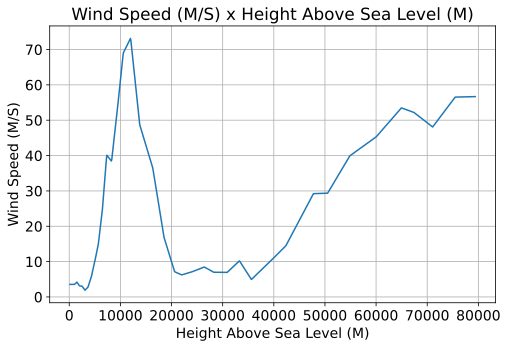

In [311]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from rocketpy.environment import Environment
Env = Environment(
    latitude=32.9901,
    longitude=-106.9751,
    elevation=1400.556
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.set_date(
    (tomorrow.year, tomorrow.month, tomorrow.day, 12)
)  # Hour given in UTC time

Env.set_atmospheric_model(type='Forecast', file='GFS')

##Set custom wind speed
#Env.set_atmospheric_model(
 #   type="custom_atmosphere",
  #  pressure=None,
   # temperature=300,
    #wind_u=[(0, 7), (1000, 10)],
    #wind_v=[(0, 3), (500, 3), (1600, 2)],
#)

Env.wind_speed()


Gravity Details

Acceleration of gravity at surface level:    9.7911 m/s²
Acceleration of gravity at  79.389 km (ASL): 9.5552 m/s²


Launch Site Details

Launch Date: 2024-02-28 12:00:00 UTC
Launch Site Latitude: 32.99010°
Launch Site Longitude: -106.97510°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315458.79 W    3651921.75 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.3 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.389 km
Forecast Time Period: From  2024-02-27 00:00:00  to  2024-03-14 00:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 4.16 m/s
Surface Wind Direction: 358.12°
Surface Wind Heading: 178.12°
Surface Pressure: 853.27 hPa
Surface Temperature: 282.11 K
Surface Air Density: 1.054 kg/m³
Surface Speed of Sound: 336.71 m/s


Earth Model Details

Earth Ra

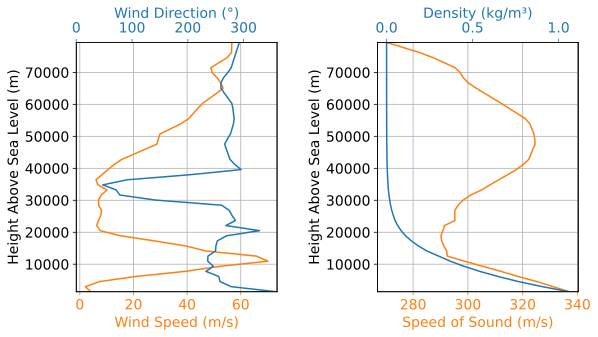

In [312]:
Env.info()

### Creating Thrust Curve

---

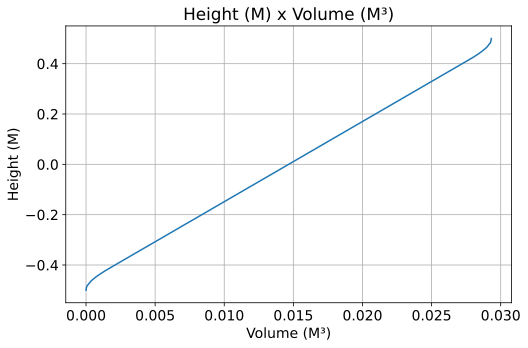

7.6836


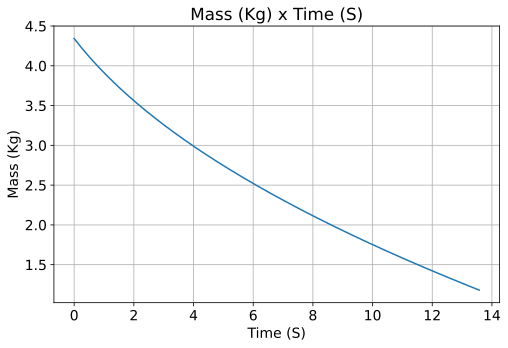

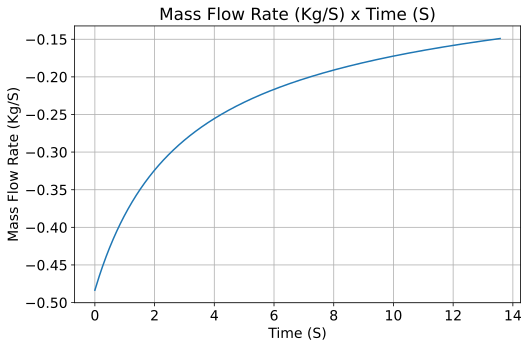

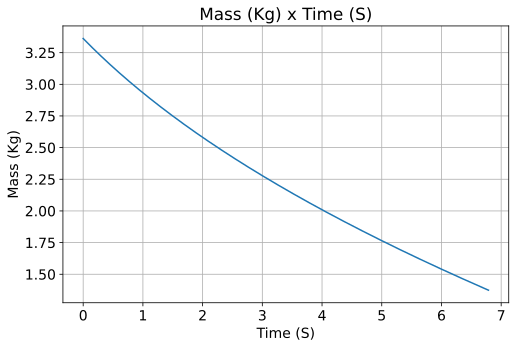

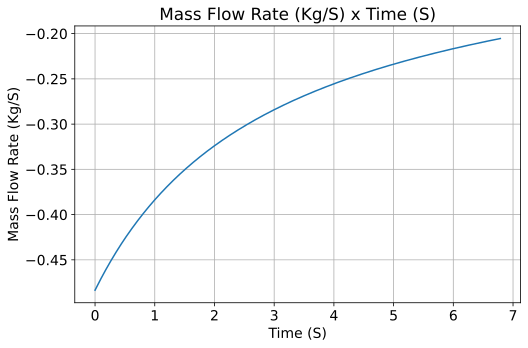

In [313]:
from rocketpy.motors.liquid_motor import LiquidMotor
from rocketpy.motors import CylindricalTank, Fluid, TankGeometry
from rocketpy.motors.tank import MassFlowRateBasedTank

oxidizer_liq = Fluid(name="LOX_l", density=1140.0)
oxidizer_gas = Fluid(name="LOX_g", density=1.43)
fuel_liq = Fluid(name="ethanol_l", density=789)
fuel_gas = Fluid(name="ethanol_g", density=1.59)

tanks_shape = CylindricalTank(0.1, 1, True)
#tanks_shape.radius.plot(equal_axis=True)
tanks_shape.inverse_volume.plot()

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=tanks_shape,
    flux_time=13.57429718875502	,
    initial_liquid_mass=V_oxinit/1000*rho_LOX,
    initial_gas_mass=0.01,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out= "RocketPy/data/motors/liquid_motor_example/LE2_oxmdot.csv", #####UPDATE
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=tanks_shape,
    flux_time=13.57429718875502/2, ###update
    initial_liquid_mass=V_ethinit/1000*rho_ETH,
    initial_gas_mass=0.01,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out= "RocketPy/data/motors/liquid_motor_example/LE2_fuelmdot.csv", #####UPDATE
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

# Add the tank to the LiquidMotor

Propmass = V_oxinit/1000*rho_LOX+V_ethinit/1000*rho_ETH
print(Propmass)

LiquidMotor.propellant_initial_mass = Propmass

LE2 = LiquidMotor(
            thrust_source="RocketPy/data/motors/LE2.eng",
            dry_mass=13.6644701,
            center_of_dry_mass_position=2.798318,
            dry_inertia=(8.5736980382,8.5733983752,0.0334267644),
            nozzle_radius=0.0515/2,
           # burn_time,
            nozzle_position=0,
            reshape_thrust_curve=False,
            interpolation_method="linear",
            coordinate_system_orientation="nozzle_to_combustion_chamber",
)

# Add tanks to the LiquidMotor
LE2.add_tank(tank=oxidizer_tank, position=0.8) #distance from nozzle outlet
LE2.add_tank(tank=fuel_tank, position=1.86)

oxidizer_tank.fluid_mass.plot()
oxidizer_tank.net_mass_flow_rate.plot()

fuel_tank.fluid_mass.plot()
fuel_tank.net_mass_flow_rate.plot()

In [314]:
#LE2.info()

### Creating a Rocket

---

In [315]:
from rocketpy.rocket.rocket import Rocket
ALULA = Rocket(
        #self,
        radius=0.0785,
        mass= 30.0,   #36.338, #*0.9,     #  total dry
        inertia=(40.32089762,40.32707615,0.16968255,-0.00501791,-0.33114339,0.44168709),
        power_off_drag="RocketPy/data/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        power_on_drag="RocketPy/data/LE2_Inserts_Drag_-_Sheet1.csv", ##UPDATE
        center_of_mass_without_motor=1.996,
        coordinate_system_orientation="tail_to_nose",
)

ALULA.add_motor(LE2, position=0) # origin = nozzle outlet


railButtons = ALULA.set_rail_buttons(
    upper_button_position=0.18,
    lower_button_position=-1.4246,
    angular_position=60,
)

NoseCone = ALULA.add_nose(length=0.9271, kind="vonKarman", position=3.99)

FinSet = ALULA.add_trapezoidal_fins(
    n=3,
    root_chord =0.305,
    tip_chord=0.102,
    span=0.152,
    position=0.4,
    sweep_angle=33.7
)

To add the motor to our rocket we need only inform what motor we are adding (Pro75M1670) and inform the position, in meters, of the motor's nozzle exit area relative to the previously defined coordinate system.


In [316]:
ALULA.info()


Inertia Details

Rocket Mass: 30.000 kg (without motor)
Rocket Dry Mass: 43.664 kg (with unloaded motor)
Rocket Loaded Mass: 51.368 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 54.938 kg*m2
Rocket Inertia (with unloaded motor) 22: 54.944 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.203 kg*m2
Rocket Inertia (with unloaded motor) 12: -0.005 kg*m2
Rocket Inertia (with unloaded motor) 13: -0.331 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.442 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0785 m
Rocket Frontal Area: 0.019359 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.251 m
Rocket Center of Dry Mass - Nozzle Exit: 2.247 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.389 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.208 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.707/rad

Center of Pressure

Nose Cone Cente

#### Adding Parachutes + Simulating flight
---


In [317]:
main = ALULA.add_parachute(
    name="main", #84"d - 120"d
    cd_s=3.464577329*2.2, #^7.07050353*2.2,
    trigger=259.07,  # ejection altitude: 1000ft
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

drogue = ALULA.add_parachute(
    name="drogue", #60''d
    cd_s=1.767638271*2.2,
    trigger="apogee",  # ejection at apogee
    sampling_rate=105,
    lag=0, #1.5
    noise=(0, 8.3, 0.5),
)

In [318]:
from rocketpy.simulation.flight import Flight
test_flight = Flight(
  rocket=ALULA, environment=Env, rail_length=18.288, inclination=85, heading=0
)

## Analyzing the Results
---



Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1471.33 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: -4.15 m/s
Lateral Surface Wind Speed: -0.13 m/s


Launch Rail

Launch Rail Length: 18.288  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 1.166 s
Rail Departure Velocity: 31.465 m/s
Rail Departure Stability Margin: 6.476 c
Rail Departure Angle of Attack: 7.453°
Rail Departure Thrust-Weight Ratio: 3.622
Rail Departure Reynolds Number: 3.012e+05


Burn out State

Burn out time: 14.297 s
Altitude at burn out: 1636.644 m (AGL)
Rocket velocity at burn out: 186.863 m/s
Freestream velocity at burn out: 187.530 m/s
Mach Number at burn out: 0.567
Kinetic energy at bu

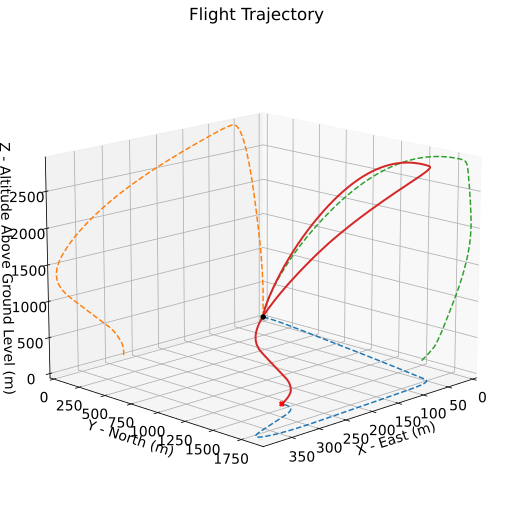



Trajectory Kinematic Plots



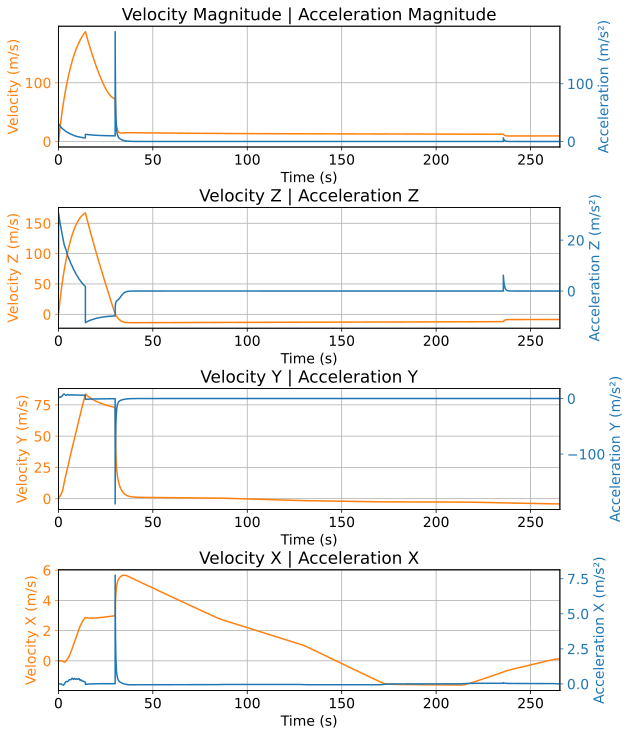



Angular Position Plots



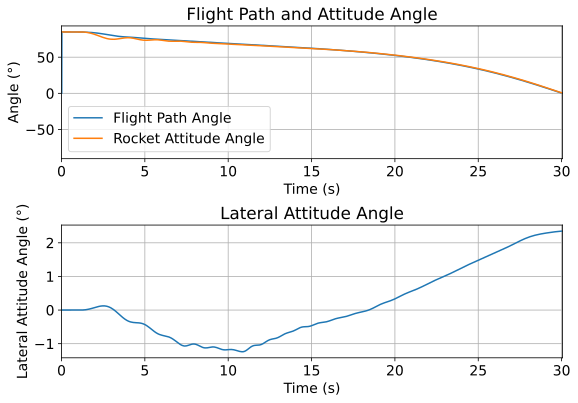



Path, Attitude and Lateral Attitude Angle plots



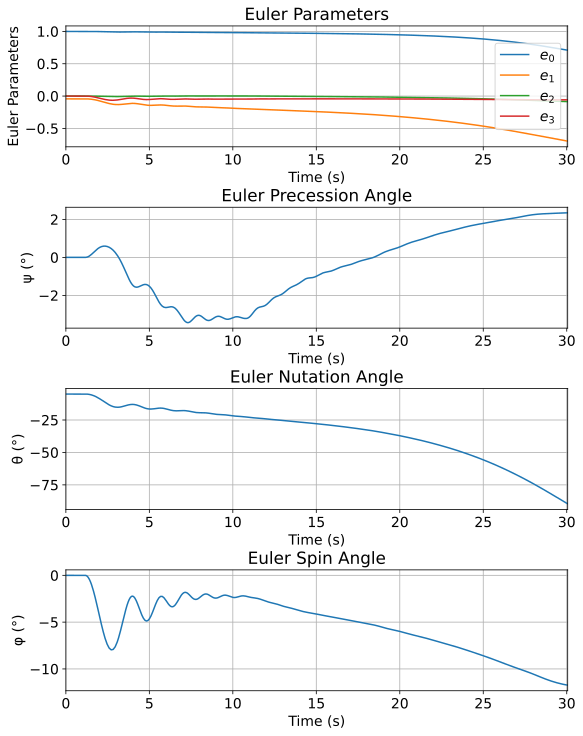



Trajectory Angular Velocity and Acceleration Plots



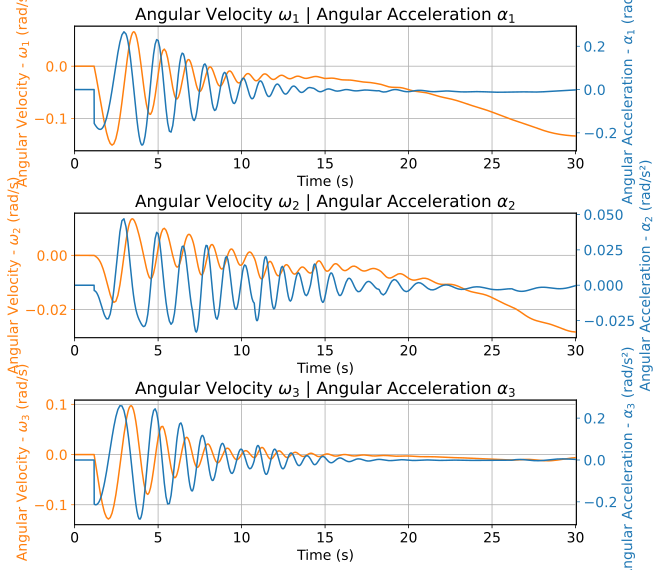



Aerodynamic Forces Plots



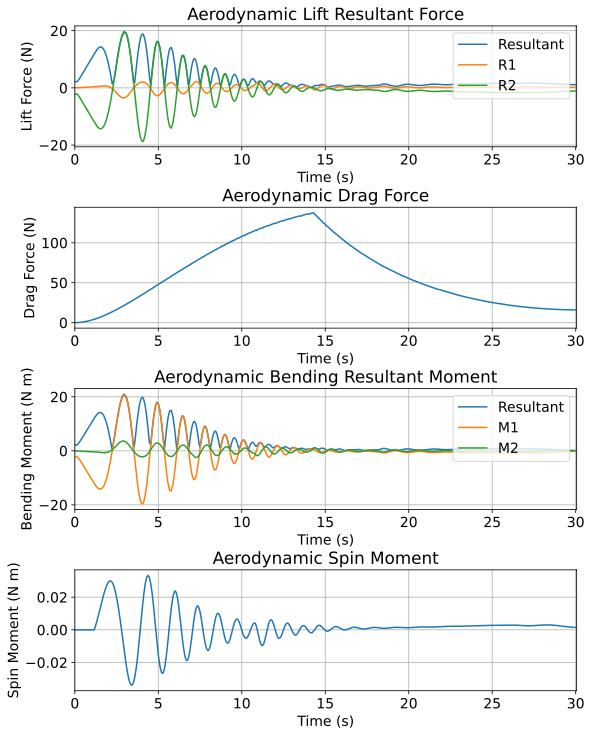



Rail Buttons Forces Plots



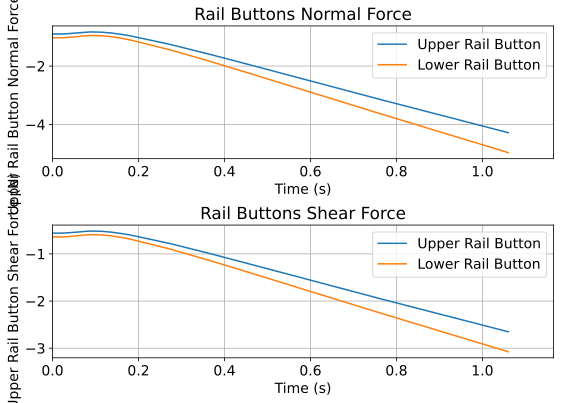



Trajectory Energy Plots



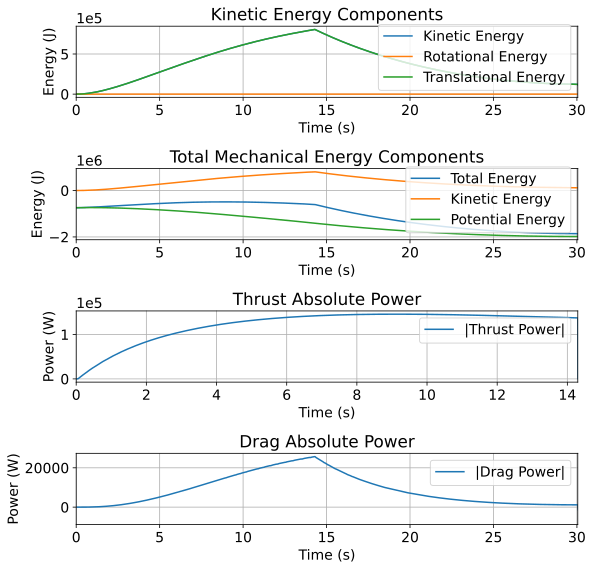



Trajectory Fluid Mechanics Plots



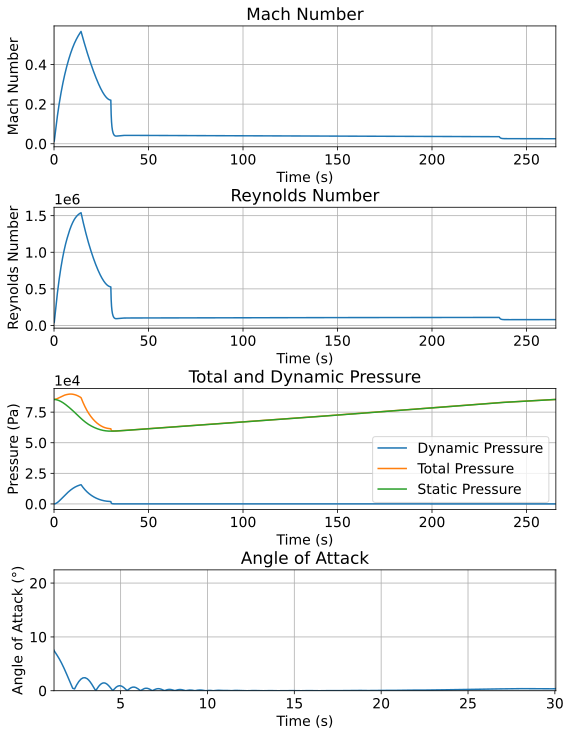



Trajectory Stability and Control Plots



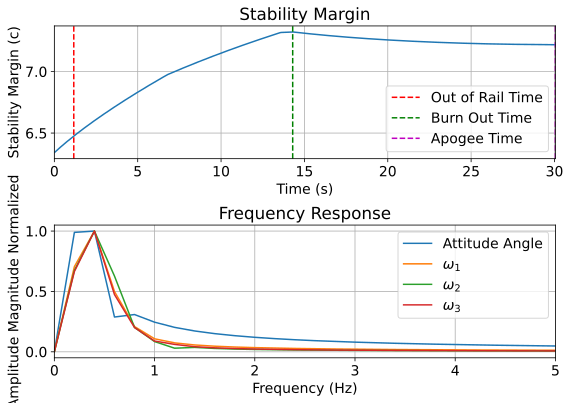



Rocket and Parachute Pressure Plots



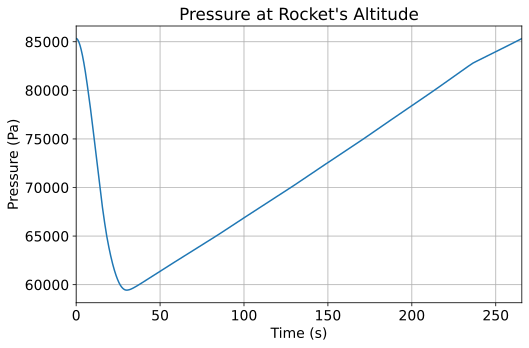


Parachute:  main


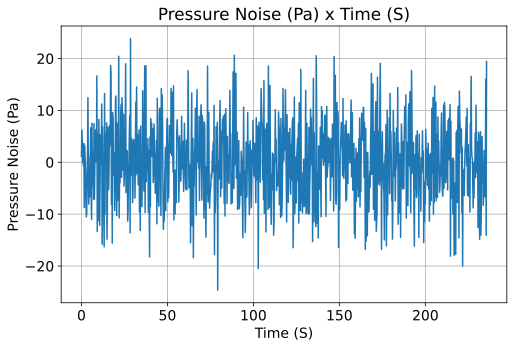

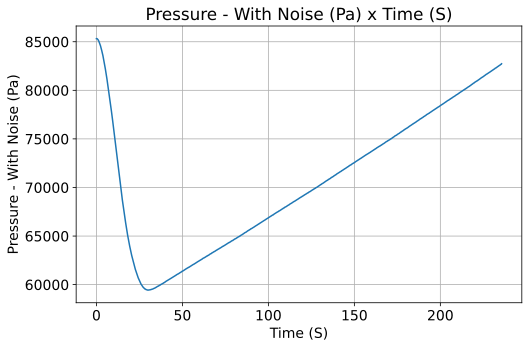

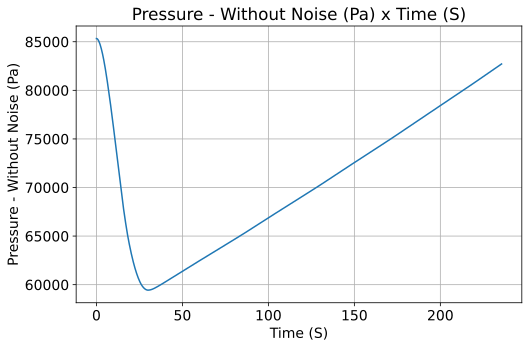


Parachute:  drogue


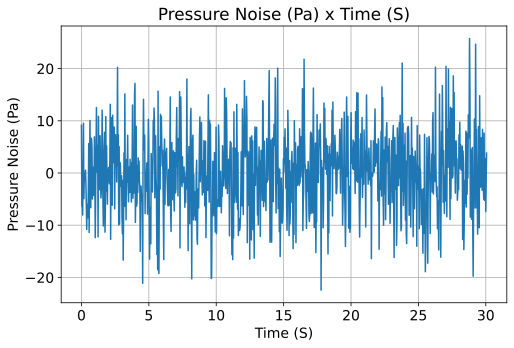

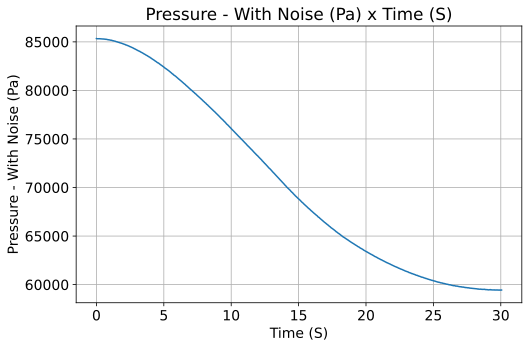

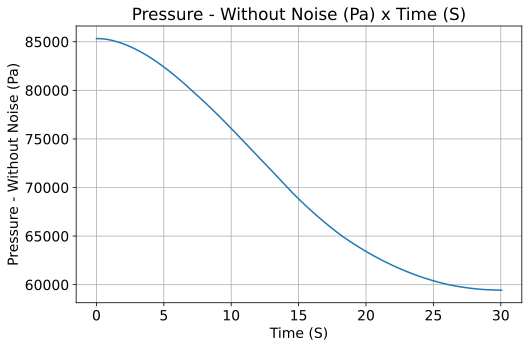

In [319]:
test_flight.all_info()

Export Flight Trajectory to a .kml file so it can be opened on Google Earth


In [320]:
test_flight.export_kml(
    file_name="trajectory.kml",
    extrude=True,
    altitude_mode="relative_to_ground",
)

File  trajectory.kml  saved with success!


### Apogee as a Function of Mass
---


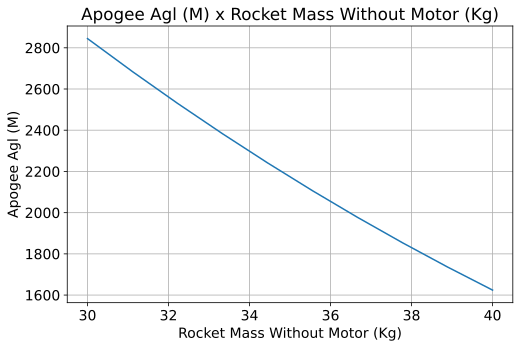

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Apogee AGL (m))'

In [245]:
from rocketpy.utilities import apogee_by_mass

apogee_by_mass(flight=test_flight, min_mass=30, max_mass=40, points=10, plot=True)

### Out of Rail Speed as a Function of Mass

 A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.


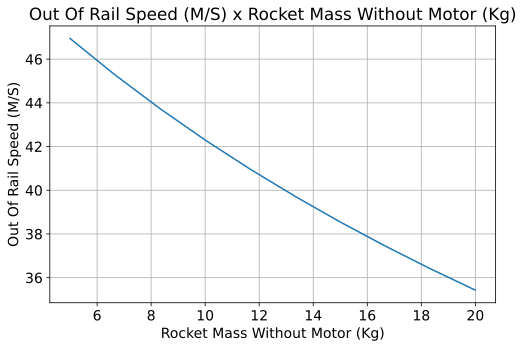

'Function from R1 to R1 : (Rocket Mass without motor (kg)) → (Out of Rail Speed (m/s))'

In [246]:
from rocketpy.utilities import liftoff_speed_by_mass

liftoff_speed_by_mass(flight=test_flight, min_mass=5, max_mass=20, points=10, plot=True)

### Dynamic Stability Analysis

 Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial. dynamic stability of ALULA varies if we change the fins span by a certain factor.


Simulating Rocket with Static Margin of 2.759->3.677 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 4.035->4.952 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 5.310->6.227 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 6.585->7.502 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 7.860->8.777 c
Simulation Completed at Time: 5.0000 s


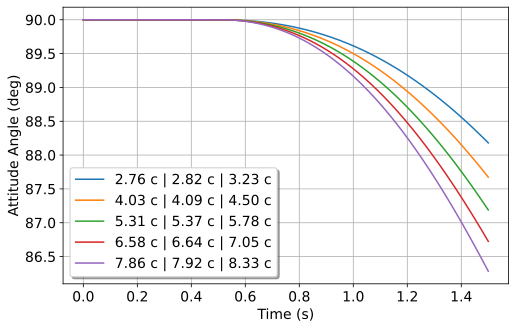

In [247]:
# Helper class
from rocketpy import Function
import copy

# Prepare a copy of the rocket
ALULA2 = copy.deepcopy(ALULA)

# Prepare Environment Class
custom_env = Environment()
custom_env.set_atmospheric_model(type="custom_atmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [-0.5, -0.2, 0.1, 0.4, 0.7]:
    # Modify rocket fin set by removing previous one and adding new one
    ALULA2.aerodynamic_surfaces.pop(-1)

    fin_set = ALULA2.add_trapezoidal_fins(
        n=4,
        root_chord=0.120,
        tip_chord=0.040,
        span=0.100,
        position=-1.04956 * factor,
    )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            ALULA2.static_margin(0),
            ALULA2.static_margin(ALULA2.motor.burn_out_time),
        )
    )
    test_flight = Flight(
        rocket=ALULA2,
        environment=custom_env,
        rail_length=5.2,
        inclination=90,
        heading=0,
        max_time_step=0.01,
        max_time=5,
        terminate_on_apogee=True,
        verbose=True,
    )
    # Store Results
    static_margin_at_ignition = ALULA2.static_margin(0)
    static_margin_at_out_of_rail = ALULA2.static_margin(test_flight.out_of_rail_time)
    static_margin_at_steady_state = ALULA2.static_margin(test_flight.t_final)
    simulation_results += [
        (
            test_flight.attitude_angle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                static_margin_at_ignition,
                static_margin_at_out_of_rail,
                static_margin_at_steady_state,
            ),
        )
    ]

Function.compare_plots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

### Characteristic Frequency Calculation

characteristic frequency of oscillation of our rocket just as it leaves the launch rail


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate first 5 seconds of Flight
flight = Flight(
    rocket=ALULA,
    environment=Env,
    rail_length=5.2,
    inclination=90,
    heading=0,
    max_time_step=0.01,
    max_time=5,
)

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = flight.attitude_angle(t) - np.mean(flight.attitude_angle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]

# Create the plot
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[0].grid()
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
ax[1].grid()
plt.subplots_adjust(hspace=0.5)
plt.show()